<a href="https://colab.research.google.com/github/marisabelsubia/Programmazione-Avanzata-2025/blob/main/Plotting_%26_Running_guide_Geant4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting and Running guide - Geant4
### Author: Maria Isabel Subia

This Colab Notebook showcases the main functionalities and results of the Geant4 project. The README file found on the project folder also contains technical details.

About the project:
* Simulate using Geant4 a cone of breast tissue. The base of the cone should have a diameter of 10 cm, and the height should be 10 cm.
 * Inside the cone, place a spherical nodule with a diameter of 1 cm and a higher density.
 * Create a collimated beam of gamma rays with an energy of 10 MeV coming from above (perpendicular to the cone) and directed at the nodule.
* Study the deposited dose:
 * Measure the total dose deposited in the breast tissue traversed by the gamma beam and plot it as a function of:
   * Depth
   * Gamma beam energy (using 2 MeV, 6 MeV, and 10 MeV)

 Compare the deposited dose in the 1 cm region corresponding to the nodule with that in the adjacent healthy tissue.



# The basic structure of the G4 application



1. Main application
2. Detector construction
3. Physics list
4. Primary generator
5. Action classes
6. Run manager



**Main Application - BreastSimulation.cc**

Sets up the G4 run manager, initializes all components, and starts the simulation. Uses: G4RunManager

**Detector Construction Files - BreastDetectorConstruction.hh / .cc**

These files define the entire simulation geometry

Header file .hh: Declares the BreastDetectorConstruction class inheriting from G4VUserDetectorConstruction. Declares methods for constructing the geometry. Defines private variables for materials and logical volumes. Provides accessor methods for volumes

Implementation file .cc: Implements the Construct() method that builds the geometry. Defines materials using the NIST database. Creates the world volume, breast cone, and nodule. Places volumes in a hierarchical structure. Handles rotations and positioning. Returns the physical world volume

**Primary Generator Files - BreastPrimaryGeneratorAction.hh/.cc**

The header (.hh) file: Declares the class inheriting from G4VUserPrimaryGeneratorAction. Declares the GeneratePrimaries() method. Defines private variables for the particle gun

The implementation (.cc) file:bCreates a particle gun. Sets the particle type (gamma). Sets beam energy and direction. Implements GeneratePrimaries() to create particles for each event. Handles collimation and beam position.
Allows energy to be changed via messenger commands

**Run Action files- BreastRunAction.hh/cc**

These files handle the start and end of runs.

The header (.hh) file: Declares the class inheriting from G4UserRunAction. Declares methods for beginning and ending a run. Defines data structures to store dosimetry data

The implementation (.cc) file: Initializes dose collection at the beginning of a run. Calculates mass of different tissue regions. Processes collected data at the end of a run. Converts energy deposition to dose (Gy). Writes output to CSV files. Calculates tissue-specific doses and ratios


**Event Action Files-BreastEventAction.cc/.hh**

These files handle individual events.

The header (.hh) file:bDeclares the class inheriting from G4UserEventAction. Declares methods for beginning and ending an event. Provides methods to accumulate energy deposition.

The implementation (.cc) file: Resets energy accumulators at the beginning of each event. Transfers accumulated energy to the run action at the end of each event. Acts as an intermediary between stepping action and run action

**Stepping Action Files - BreastSteppingAction.hh/cc**

These files handle individual simulation steps.

The header (.hh) file: Declares the class inheriting from G4UserSteppingAction. Declares the UserSteppingAction() method

The implementation (.cc) file: Processes each simulation step. Extracts energy deposition information. Identifies which volume the step occurs in. Records position-dependent energy deposition. Separates energy deposition by tissue type. Adds debug output for tracking

**Action Initialization Files - BreastActionInitialization.hh/cc**

These files coordinate all user actions

The header (.hh) file: Declares the class inheriting from G4VUserActionInitialization. Declares Build() and BuildForMaster() methods

The implementation (.cc) file: Creates and registers all user action classes.
Handles proper initialization for multi-threading (ideally).
Passes detector construction to run action for dosimetry.



##DETAILS ON THE SIMULATION
>A shell script was defined to run simulations for all energies alltogether, obtaining 6 data files (three for dose profile plotting and three for dose comparison)

>Bin mass approximation: For simplicity, each bin will have the same mass aproximated to the healthy breast mass (*tumour mass is slightly denser*) with 1mm bins along the y direction

>Gamma beam is collimated with a 0.1 sigma with a pre-defined energy of 10MeV, energy modifiable through the corresponding macros.



## Geometry definition.
> Vertical cone to simulate patient supine position, centered on system of reference.

> Perpendicular beam from above.

> Tumour located on axis, at position 0,0,0.

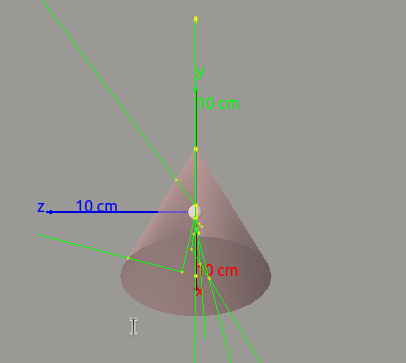

In [4]:
#!/usr/bin/env python3


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from google.colab import drive
import os

# Mount Google Drive - Run this once at the beginning
drive.mount('/content/drive')

# Set the path to your data files
data_dir = '/content/drive/My Drive/BreastOutput/geant4_final/B1/buildall'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Successfully loaded /content/drive/My Drive/BreastOutput/geant4_final/B1/buildall/depth_dose_2MeV.csv
Data shape: (999, 2)
Successfully loaded /content/drive/My Drive/BreastOutput/geant4_final/B1/buildall/depth_dose_6MeV.csv
Data shape: (999, 2)
Successfully loaded /content/drive/My Drive/BreastOutput/geant4_final/B1/buildall/depth_dose_10MeV.csv
Data shape: (998, 2)


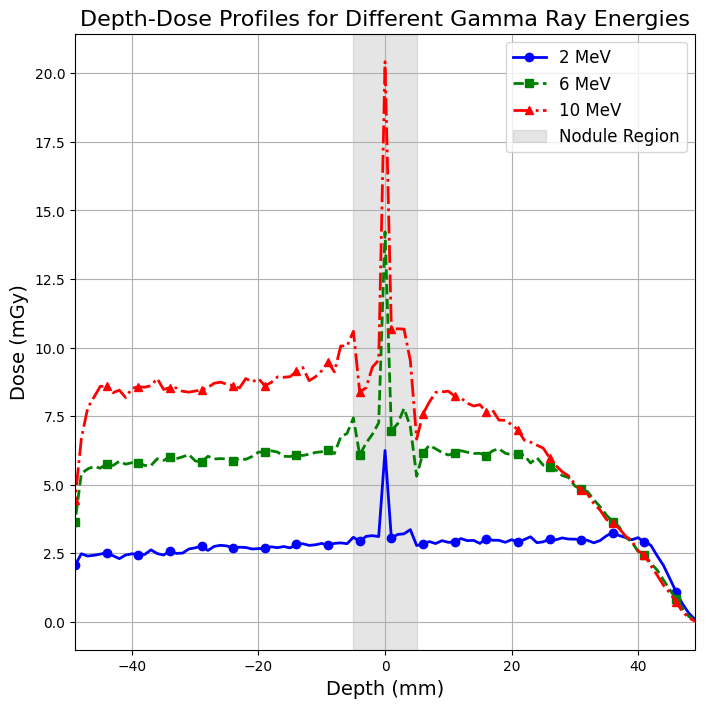

Comparison plot saved to: /content/drive/My Drive/BreastOutput/geant4_final/B1/buildall/energy_comparison_plot.png


In [5]:
#@title { vertical-output: true}

# Energy levels to compare
energies = [2, 6, 10]  # MeV

# Lists to store data
depth_dose_data = []

# Read data files for each energy
for energy in energies:
    filename = os.path.join(data_dir, f'depth_dose_{energy}MeV.csv')
    try:
        data = pd.read_csv(filename)
        depth_dose_data.append(data) # basically we made a list of dataframes
        print(f"Successfully loaded {filename}")
        print(f"Data shape: {data.shape}") #checking data shape coherence
    except Exception as e:
        print(f"Error loading {filename}: {e}")

# Plot depth-dose curves for all energies
plt.figure(figsize=(8, 8))

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']
line_styles = ['-', '--', '-.']

for i, energy in enumerate(energies):
    if i < len(depth_dose_data):
        data = depth_dose_data[i]
        plt.plot(data['Depth(mm)'], data['Dose(Gy)']*1000,
                 color=colors[i], marker=markers[i], linestyle=line_styles[i],
                 markevery=5, # Show marker every 5 points
                 linewidth=2, label=f'{energy} MeV')

# Add shaded region for nodule location (assumed 10mm diameter on the origin)
plt.axvspan(-5, 5, alpha=0.2, color='gray', label='Nodule Region')

# Add labels and title
plt.xlabel('Depth (mm)', fontsize=14)
plt.ylabel('Dose (mGy)', fontsize=14)
plt.xlim(-49,49)
plt.title('Depth-Dose Profiles for Different Gamma Ray Energies', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


# Save the plot
output_file = os.path.join(data_dir, 'energy_comparison_plot.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Comparison plot saved to: {output_file}")





## Comparison of dose analysis

Data Summary:
    Tissue        Mass  Energy (MeV)   Dose(Gy) Beam Energy
0   Nodule  565.487 mg       4059.47  11.500300       2 MeV
1  Healthy  248.212 g       37858.80   0.244347       2 MeV
2   Nodule  565.487 mg       6249.38  17.704200       6 MeV
3  Healthy  248.212 g       77503.20   0.500218       6 MeV
4   Nodule  565.487 mg       7393.85  20.946500      10 MeV
5  Healthy  248.212 g      103842.00   0.670216      10 MeV


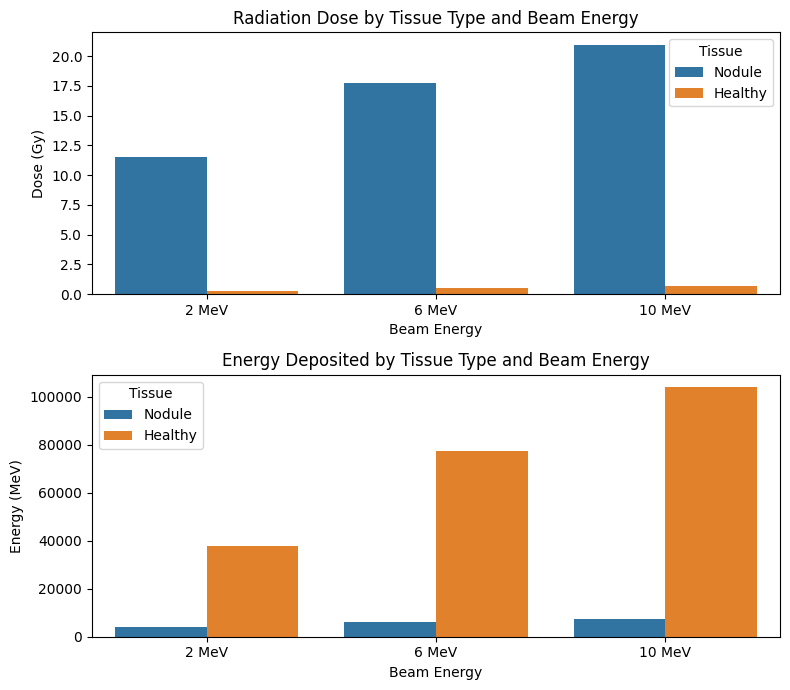


2 MeV Analysis:
  Nodule Dose: 11.500300 Gy
  Healthy Tissue Dose: 0.244347 Gy
  Dose Ratio (Nodule/Healthy): 47.07x

6 MeV Analysis:
  Nodule Dose: 17.704200 Gy
  Healthy Tissue Dose: 0.500218 Gy
  Dose Ratio (Nodule/Healthy): 35.39x

10 MeV Analysis:
  Nodule Dose: 20.946500 Gy
  Healthy Tissue Dose: 0.670216 Gy
  Dose Ratio (Nodule/Healthy): 31.25x


In [6]:
#@title { vertical-output: true}

# Function to read and process a single file
def process_file(energy):
    file_path = os.path.join(data_dir, f"tissue_comparison_{energy}MeV.csv")
    df = pd.read_csv(file_path)
    df['Beam Energy'] = f"{energy} MeV"
    return df

# Create an empty list to store dataframes
dfs = []

try:
    # Read all files and combine them
    for energy in energies:
        df = process_file(energy)
        dfs.append(df)

    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)

    # Print basic information about the data
    print("Data Summary:")
    print(combined_df)

    # Set up the figure and axes for plots
    fig, axes = plt.subplots(2, 1, figsize=(8, 7))

    # Plot 1: Dose comparison by tissue type and energy level
    sns.barplot(x='Beam Energy', y='Dose(Gy)', hue='Tissue', data=combined_df, ax=axes[0])
    axes[0].set_ylabel('Dose (Gy)')
    axes[0].set_title('Radiation Dose by Tissue Type and Beam Energy')

    # Plot 2: Energy comparison by tissue type and energy level
    sns.barplot(x='Beam Energy', y='Energy (MeV)', hue='Tissue', data=combined_df, ax=axes[1])
    axes[1].set_ylabel('Energy (MeV)')
    axes[1].set_title('Energy Deposited by Tissue Type and Beam Energy')

    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'tissue_comparison_plots.png'), dpi=300)
    plt.show()

    # Calculate and print dose ratios
    for energy in energies:
        energy_label = f"{energy} MeV"
        energy_data = combined_df[combined_df['Beam Energy'] == energy_label]

        nodule_data = energy_data[energy_data['Tissue'] == 'Nodule'].iloc[0]
        healthy_data = energy_data[energy_data['Tissue'] == 'Healthy'].iloc[0]

        nodule_dose = nodule_data['Dose(Gy)']
        healthy_dose = healthy_data['Dose(Gy)']
        dose_ratio = nodule_dose / healthy_dose

        print(f"\n{energy} MeV Analysis:")
        print(f"  Nodule Dose: {nodule_dose:.6f} Gy")
        print(f"  Healthy Tissue Dose: {healthy_dose:.6f} Gy")
        print(f"  Dose Ratio (Nodule/Healthy): {dose_ratio:.2f}x")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Please ensure all CSV files exist in {data_dir}")
 #except Exception as e:
 #   print(f"An error occurred: {e}")
 #     import traceback
 #    traceback.print_exc()